In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("albaclosatarres/football-shots-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\totor\.cache\kagglehub\datasets\albaclosatarres\football-shots-data\versions\1


Supposons que le dataset contient un fichier shots.csv (ou similaire). Tu peux lister les fichiers du path pour vérifier :

In [48]:
import os

print(os.listdir(path))

['xg_model.csv']


Ensuite, lis ton fichier avec pandas :

In [49]:
import pandas as pd

df = pd.read_csv(f"{path}/xg_model.csv")  # adapte le nom au bon fichier
print(df.head())
print(df.columns)

      x     y  is_goal      period Assisted    Zone IndividualPlay  \
0  80.8  51.6    False  SecondHalf     True  Center           True   
1  79.3  24.2    False  SecondHalf     True  Center           True   
2  80.0  59.5    False  SecondHalf     True  Center            NaN   
3  89.8  55.6    False  SecondHalf     True  Center            NaN   
4  84.9  56.2    False  SecondHalf     True  Center            NaN   

  RegularPlay LeftFoot RightFoot  ... Volley FastBreak ThrowinSetPiece  \
0        True     True       NaN  ...    NaN       NaN             NaN   
1        True      NaN      True  ...    NaN       NaN             NaN   
2         NaN      NaN      True  ...    NaN       NaN             NaN   
3         NaN      NaN       NaN  ...    NaN       NaN             NaN   
4        True     True       NaN  ...    NaN       NaN             NaN   

  Penalty OneOnOne KeyPass DirectFreekick OwnGoal OtherBodyPart DirectCorner  
0     NaN      NaN     NaN            NaN     NaN      

1. Créer des features géométriques (distance/angle)

In [50]:
import numpy as np

goal_x, goal_y = 120, 40  # dimensions StatsBomb-like (si le dataset suit ça)

df["distance"] = np.sqrt((goal_x - df["x"])**2 + (goal_y - df["y"])**2)
df["off_centre"] = np.abs(df["y"] - goal_y)


2. Préparer X (features) et y (cible)

In [51]:
# Variable cible
y = df["is_goal"]

# On garde les features géométriques + colonnes binaires déjà prêtes
feature_cols = [
    "x", "y", "distance", "off_centre",
    "LeftFoot", "RightFoot", "Head",
    "RegularPlay", "SetPiece", "Penalty", "DirectFreekick",
    "FromCorner", "ThrowinSetPiece", "DirectCorner",
    "BigChance", "OneOnOne", "KeyPass", "FastBreak"
]

X = df[feature_cols]

# Convertir tout ce qui est True/False/NaN en 1/0
X = X.fillna(False)     # NaN = False
X = X.astype(int)       # True/False → 1/0

print(X.head())

    x   y  distance  off_centre  LeftFoot  RightFoot  Head  RegularPlay  \
0  80  51        40          11         1          0     0            1   
1  79  24        43          15         0          1     0            1   
2  80  59        44          19         0          1     0            0   
3  89  55        33          15         0          0     1            0   
4  84  56        38          16         1          0     0            1   

   SetPiece  Penalty  DirectFreekick  FromCorner  ThrowinSetPiece  \
0         0        0               0           0                0   
1         0        0               0           0                0   
2         0        0               0           1                0   
3         0        0               0           1                0   
4         0        0               0           0                0   

   DirectCorner  BigChance  OneOnOne  KeyPass  FastBreak  
0             0          0         0        0          0  
1             0 

C:\Users\totor\AppData\Local\Temp\ipykernel_12012\3030354898.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna(False)     # NaN = False


3. Modèle simple (régression logistique)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:,1]

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("LogLoss:", log_loss(y_test, y_pred_proba))
print("Brier:", brier_score_loss(y_test, y_pred_proba))


AUC: 0.7950773267053299
LogLoss: 0.2922679498797938
Brier: 0.08540604576752743


In [53]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_pitch_shots(df: pd.DataFrame, x_col="x", y_col="y", xg_col="xg", arrows=True,
                     title="Carte des tirs (taille ∝ xG, couleur ∝ xG)"):
    """
    Affiche un terrain 100x80 (classique Opta/Wyscout) et les tirs.
    - Taille des ronds ∝ xG
    - Couleur des ronds ∝ xG
    - Flèches vers le but (centre) si arrows=True
    """
    longueur = 100   # longueur terrain
    largeur = 100     # largeur terrain
    arrow_scale = 18
    
    # Filtrage basique
    d = df[[x_col, y_col, xg_col]].dropna()
    d = d[(d[x_col].between(0, longueur)) & (d[y_col].between(0, largeur))]

    # Taille et couleur selon xG
    sizes = (d[xg_col].clip(0, 1) * 500) + 10
    colors = d[xg_col].clip(0, 1)

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xlim(0, longueur)
    ax.set_ylim(0, largeur)

    # Contours du terrain
    ax.plot([0, longueur, longueur, 0, 0], [0, 0, largeur, largeur, 0])
    ax.plot([longueur/2, longueur/2], [0, largeur])                  # ligne médiane
    ax.plot([0, 18, 18, 0], [18, 18, largeur-18, largeur-18])        # surface gauche
    ax.plot([longueur, longueur-18, longueur-18, longueur], 
            [18, 18, largeur-18, largeur-18])                        # surface droite
    ax.scatter([11, longueur-11], [largeur/2, largeur/2], s=20)      # points de penalty
    ax.add_patch(plt.Circle((longueur/2, largeur/2), 9.15, fill=False))  # rond central

    # Scatter des tirs (taille et couleur ∝ xG)
    sc = ax.scatter(d[x_col], d[y_col], s=sizes, c=colors, cmap="coolwarm", alpha=0.7)

    # Flèches vers le but (au centre du but droit)
    if arrows:
        gx, gy = longueur, largeur/2
        dx = gx - d[x_col].values
        dy = gy - d[y_col].values
        ax.quiver(d[x_col].values, d[y_col].values, dx, dy,
                  angles='xy', scale_units='xy', scale=arrow_scale,
                  width=0.002, alpha=0.5, color="black")

    # Barre de couleur
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label("xG (probabilité de but)")

    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlabel("x (0 → 100)")
    ax.set_ylabel("y (0 → 80)")
    plt.show()


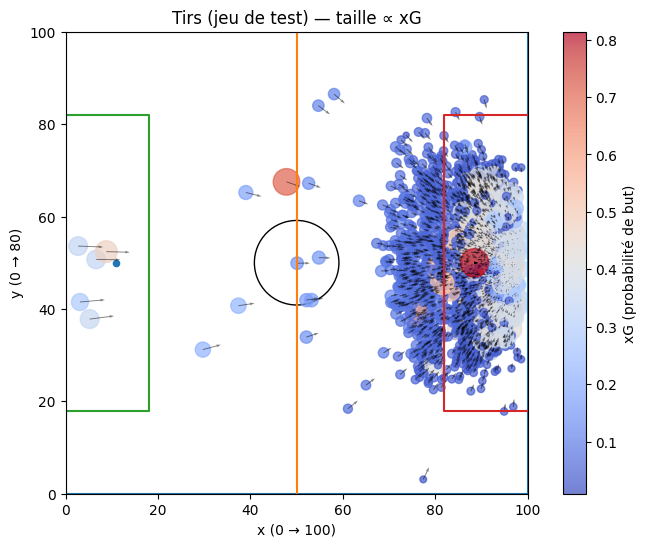

In [54]:
df_test = df.loc[X_test.index].copy()
df_test["xg"] = y_pred_proba
plot_pitch_shots(df_test, x_col="x", y_col="y", xg_col="xg",
                 title="Tirs (jeu de test) — taille ∝ xG")
